Author: SEKHAR MEKALA

Date: 12/01/2015

Project: Analysis of Diseases data set

#Index
[1. Abstract](#Abstract)

[2. Importing the required packages](#import)

[3. Reading the file](#file_read)     
 
[4. Analysis at the state population level](#Analysis_Pop)

[5. Analysis of Disease growth over years](#disease_growth)

[6. Analysis of Diseases trend in men and women](#gender)

[7. Top diseases analysis](#top_diseases)

[8. Principal Component Analysis](#PCA)

[9. Analysis Summary](#Analysis_Summary)

<a id='Abstract'></a>
###1. Abstract
The main aim of this project is to perform statistical analysis on the diseases data set found at http://catalog.data.gov/dataset/infectious-disease-cases-by-county-year-and-sex. This data set has the following attributes:

* Disease
* County
* Year
* Sex
* Count
* Population
* Rate ($\frac{{count}\mbox{ . }{10^5}}{population}$)

The data set contains diseases information from 2001 to 2014, in the state of California.

We will perform statistical analysis to analyze the diseases trend at the State level, at the Counties level and if the diseases effect is different among men and women. Since this is an observational study, we cannot get the cause and effect relationship among the variables. In this document where ever I refer to "effect of a disease", I am not referring to the "cause and effect relationship". The phrase "effect of a disease" implies that the disease has occurred in a given count of population.

The ultimate goal of this analysis is to explore which diseases effect most of the people in California.  

** NOTE: We will confine our analysis to the diseases, which have effected at least 2000 people in at least one year (between 2001 to 2014)**


<a id='import'></a>
###2. Importing the required packages

In [1]:
%matplotlib inline
import pandas as pd
from pandas import Series,DataFrame
import math
import os
import csv
import re
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display, HTML
from matplotlib.mlab import PCA as mlabPCA

<a id='file_read'></a>
###3. Reading the file
The file must be named as "Infectious_Disease.csv". We will read this file into a Data Frame (*disease_df*)

####3.1 Enter the file location

In [2]:
dir = raw_input("\nEnter the directory where the input file is located\n ==>") 


Enter the directory where the input file is located
 ==>C:\Users\Sekhar\Documents\Python Scripts


In [3]:
import os
os.chdir(dir)

fsock = open('Infectious_Disease.csv')
file_lines = fsock.readlines()
fsock.close()
l = [(i.rstrip("\n")).split(",")for i in file_lines]
disease_list = list()
county_list = list()
year_list = list()
sex_list = list()
count_list = list()
population_list = list()
rate_list = list()

for j in range(1,len(l)):
               l_len = len(l[j])
               l_temp = l[j][0:l_len - 6]
               l_temp = ",".join(l_temp) 
               disease_list.append(l_temp)
 
               county_list.append(l[j][-6]) 

               year_list.append(int(l[j][-5])) 

               sex_list.append(l[j][-4]) 

               count_list.append(int(l[j][-3])) 

               population_list.append(int(l[j][-2])) 

               rate_list.append(float(l[j][-1])) 
                
                
df = DataFrame()
df['disease'] = disease_list 
df['county'] = county_list
df['year'] = year_list
df['sex'] = sex_list
df['count'] = count_list
df['population'] = population_list
df['rate'] = rate_list


disease_df = df.convert_objects(convert_numeric=True)

##If county is California, then it represents the data at the state level. 
##We will eliminate this data, so than we can alalyze the data at the county level

disease_df_state = disease_df[disease_df['county'] == 'California'] 

disease_df = disease_df[disease_df['county'] != 'California']

#disease_df = df
#print disease_df.head()
print disease_df.describe(include='all')
disease_df.dtypes

                      disease  county           year     sex          count  \
count                  139374  139374  139374.000000  139374  139374.000000   
unique                     65      58            NaN       3            NaN   
top     "Typhoid Fever, case"   Marin            NaN    Male            NaN   
freq                     2436    2403            NaN   46458            NaN   
mean                      NaN     NaN    2007.857678     NaN      41.327816   
std                       NaN     NaN       4.052999     NaN     665.090984   
min                       NaN     NaN    2001.000000     NaN       0.000000   
25%                       NaN     NaN    2004.000000     NaN       0.000000   
50%                       NaN     NaN    2008.000000     NaN       0.000000   
75%                       NaN     NaN    2011.000000     NaN       1.000000   
max                       NaN     NaN    2014.000000     NaN   54363.000000   

             population           rate  
count     

disease        object
county         object
year            int64
sex            object
count           int64
population      int64
rate          float64
dtype: object

<a id='Required_DS'></a>
####3.2 Required data structures for the analysis
The **"sex"** variable of the data frame has three different values: **"Total", "Female" and "Male"**. The **"Total"** value in **"sex"** represents the total population (sum of **"Male"** and **"Female"** populations in the **"population"** variable). The **"disease"** variable has **65 different diseases (unique)**. There are **59 different counties** (as per the **"county"** variable).

The **county** variable of the input file contains all the counties in **California state**. But this variable also contains a value of **California**, which signifies the disease information at the state level. 

We will create two data frames: **disease_df_state** and **disease_df**. The **disease_df_state** will contain all the rows for which the **county = 'California'**, and the data frame **disease_df** contains all the rows, for which county is **NOT equal to 'California'**

Depending on the need we will create other data sets

<a id='Analysis_Pop'></a>
###4. Analysis at the state population level
####4.1 Data munging
We will begin our analysis at the over all state's population level. We will ignore the counties and the sex variables of the data set, in this analysis. After the analysis at the state level, we will include the sex and county variables in our analysis. To make our python statements simple, we will create a data frame **df_totals**, that includes the data where **sex = Total** (this will eliminate the gender). We will also sum the populations group by the year.

In [4]:
df_totals = disease_df[disease_df['sex'] == 'Total']

df_totals = df_totals.groupby(['year','disease'])['count','population'].sum()
df_totals['rate'] = df_totals['count'] / df_totals['population'] * 10**5
df_totals = df_totals.reset_index()
df_totals.describe(include="all")
print df_totals.head()

   year                disease  count  population      rate
0  2001  "Botulism, Foodborne"      4    34514777  0.011589
1  2001      "Botulism, Other"      0    34514777  0.000000
2  2001      "Botulism, Wound"     20    34514777  0.057946
3  2001        "Plague, human"      0    34514777  0.000000
4  2001        "Rabies, human"      1    34514777  0.002897


Let us get the disease data that has effected at least 2000 people, all over the state in at least 1 year. The following command will create a **df_pivot** data frame, which has each disease as the column. This transformation is needed to plot graphs for visual analysis. **There are 11 diseases which have effected at least 2000 people in at least 1 year (between 2001 and 2014)**. We will confine our analysis to these 11 diseases only, in the rest of this document

In [5]:
#Let us get only the diseases that have effected at least 2000 people in the state 
df = df_totals[df_totals['count'] >= 2000]

df =  df[['disease','year','rate', 'count']]
df_pivot = df.pivot('year','disease','rate')
#Replace all NaN with 0
df_pivot = df_pivot.fillna(0)
df_pivot = df_pivot.reset_index()
print df_pivot.head()

disease  year  Campylobacteriosis   Chlamydia  Coccidioidomycosis  \
0        2001           16.253908  294.337698            0.000000   
1        2002           16.259146  316.994680            0.000000   
2        2003           14.763646  328.854924            5.761354   
3        2004           14.213465  345.237302            7.095545   
4        2005           13.157296  358.948259            7.886041   

disease  Early Syphilis  Giardiasis  Gonorrhea        HIV  Pertussis  \
0              0.000000    8.593421  67.463858  15.477429   0.000000   
1              0.000000    7.060608  70.611804  16.399385   0.000000   
2              6.004354    6.179540  72.594756  14.458484   0.000000   
3              6.298450    6.217342  85.250028  13.578586   0.000000   
4              7.727654    6.621718  94.751981  13.079491   8.847483   

disease  Salmonellosis  Shigellosis  Tuberculosis  
0            11.997760     6.382773      9.645144  
1            11.760048     7.939249      9.07833

####4.2(a) Plotting the diseases trend (Part-1)
The following graph will display how the diseases have effected between 2001 and 2014. 

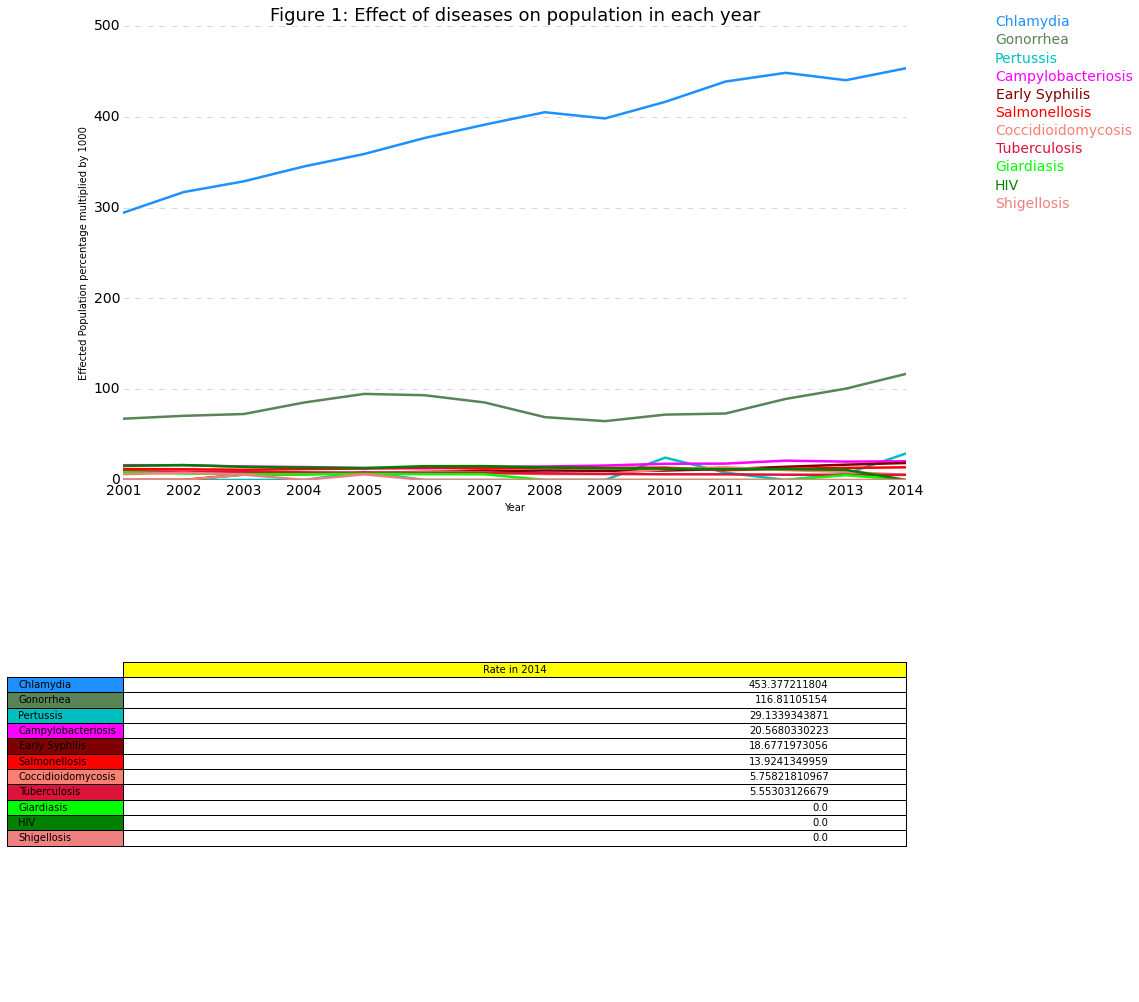

In [6]:
#Let us plot the data 

color_sequence = ['dodgerblue','darksage','c','magenta','maroon','r','salmon','crimson',
'lime','g','lightcoral','slateblue','darkolivegreen','gray','violet','orange',
'y', 'b','darkviolet','saddlebrown','black']

#use 2 subplots, one for graph and the other for table
fig, ax = plt.subplots(nrows=2, ncols = 1, figsize=(12, 14))

# Remove the plot frame lines in first plot. They are unnecessary here.
ax[0].spines['top'].set_visible(False)
ax[0].spines['bottom'].set_visible(False)
ax[0].spines['right'].set_visible(False)
ax[0].spines['left'].set_visible(False)

# Ensure that the axis ticks only show up on the bottom and left of the plot.
# Ticks on the right and top of the plot are generally unnecessary.
ax[0].get_xaxis().tick_bottom()
ax[0].get_yaxis().tick_left()

#After this statement, all the plt statements will be applied to first plot
plt.sca(ax[0])

# Limit the range of the plot to only where the data is.
# Avoid unnecessary whitespace.
plt.xlim(2001, 2014)
plt.ylim(0, 500)

# Make sure your axis ticks are large enough to be easily read.
# You don't want your viewers squinting to read your plot.
plt.xticks(range(2001, 2015, 1), fontsize=14)

plt.yticks(range(0, 600, 100), fontsize=14)


# Provide tick lines across the plot to help your viewers trace along
# the axis ticks. Make sure that the lines are light and small so they
# don't obscure the primary data lines.
for y in range(0, 600, 100):
    plt.plot(range(2001, 2015), [y] * len(range(2001, 2015)), '--',
             lw=0.5, color='black', alpha=0.3)


# Remove the tick marks; they are unnecessary with the tick lines we just
# plotted.
plt.tick_params(axis='both', which='both', bottom='off', top='off',
                labelbottom='on', left='off', right='off', labelleft='on')


# Now that the plot is prepared, it's time to actually plot the data!

#Get the diseases list in the descending order of rates (the diseases have effected atleast 500 people) in 2014 year

u = df_pivot[df_pivot['year'] == 2014]
u = pd.melt(u,id_vars=['year']).sort('value', ascending = [0])
diseases = u['disease']


i = 500
for rank, column in enumerate(diseases):
    # Plot each line separately with its own color.
    #column_rec_name = column.replace('\n', '_').replace(' ', '_').lower()
    column_rec_name = column
    #df_pivot.year will just give the unique year values
    line = plt.plot(df_pivot.year,
                    df_pivot[column_rec_name],
                    lw=2.5,
                    color=color_sequence[rank])

    plt.text(2015.5, i, column, fontsize=14, color=color_sequence[rank])
    i = i - 20


plt.title('Figure 1: Effect of diseases on population in each year'
          , fontsize=18, ha='center')
plt.xlabel('Year')
plt.ylabel('Effected Population percentage multiplied by 1000')
value_list = []

l = u['value'].values
value_list = [[i] for i in l]


#After this statement, all the plt statements will be applied to second plot
plt.sca(ax[1])
plt.axis('off')
the_table = plt.table(cellText=value_list,
                    rowLabels=list(diseases),
                   rowColours=color_sequence, loc='center',fontsize=14,
                    colLabels=['Rate in 2014'],colLoc='center',colColours=['yellow'])


# Adjust layout to make room for the table:
#plt.subplots_adjust(left=0.2, bottom=0.2)

fig.tight_layout() 
#plt.subplots_adjust(hspace=0)


####4.2(a) Analysis
The above graph has plotted the effect of diseases on the population for all the years between 2001 and 2014. We have shown the diseases that have effected at least 2000 people in at least one year since 2001 (till 2014). The "Rate" variable is nothing but the percentage of effected population, multiplied by 1000. For instance, if rate is 116.811 for a disease, then that disease has effected 0.116811% or 0.00116811 (proportion) of the population

From the above plot, we can infer the following:
* The "chalmydia" disease is always on top, since 2001, and its effect has consistently increased among the population since 2001 (although we see some down trend in 2008/2009 and 2012/2013 years).
* The same is applicable to "Gonorrhea". This disease is ranked second (based on its effect on population) consistently. 

Other than these top 2 diseases, we are not able to analyze how the other diseases have effected, since the trend lines have overlapped. Let us plot a similar graph, excluding the top 2 diseases ("chalmydia" and "Gonorrhea").

####4.2(b) Plotting the diseases trend (Part-2)
In the following code, we will plot the effect of diseases on the over all population. This graph is similar to the graph in *Figure-1*, but we eliminated the top 2 diseases, so that we can analyze the other diseases. So we will be plotting all the diseases effect from 2001 to 2014 (excluding "chalmydia" and "Gonorrhea"). These diseases have effected at least 2000 people in at least 1 year (between 2001 and 2014)

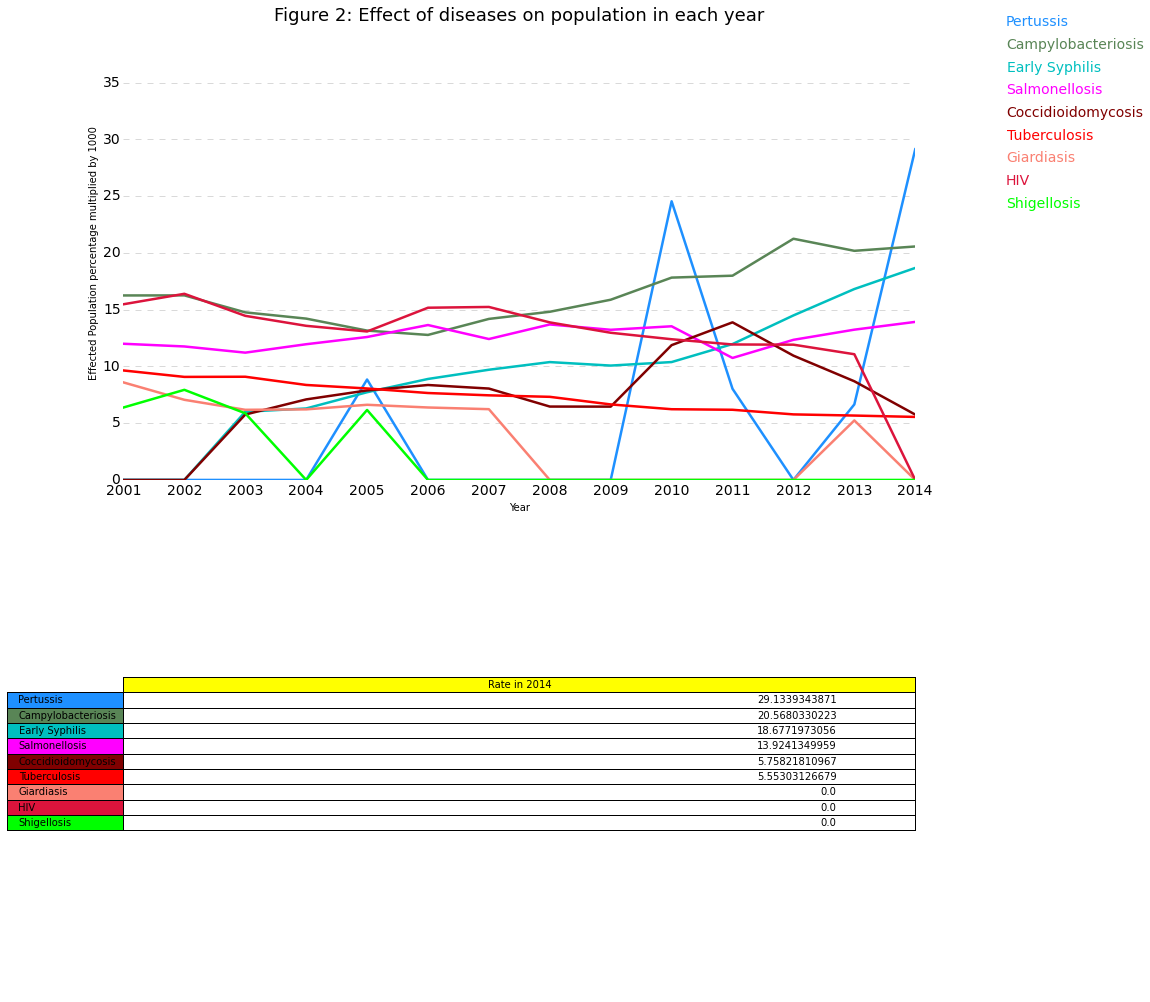

In [7]:
#print diseases
#print diseases[(diseases != 'Chlamydia') & (diseases != 'Gonorrhea')]
#print u['value'].values[2:]

#Let us plot the data 

color_sequence = ['dodgerblue','darksage','c','magenta','maroon','r','salmon','crimson',
'lime','g','lightcoral','slateblue','darkolivegreen','gray','violet','orange',
'y', 'b','darkviolet','saddlebrown','black']

#use 2 subplots, one for graph and the other for table
fig, ax = plt.subplots(nrows=2, ncols = 1, figsize=(12, 14))

# Remove the plot frame lines in first plot. They are unnecessary here.
ax[0].spines['top'].set_visible(False)
ax[0].spines['bottom'].set_visible(False)
ax[0].spines['right'].set_visible(False)
ax[0].spines['left'].set_visible(False)

# Ensure that the axis ticks only show up on the bottom and left of the plot.
# Ticks on the right and top of the plot are generally unnecessary.
ax[0].get_xaxis().tick_bottom()
ax[0].get_yaxis().tick_left()

#After this statement, all the plt statements will be applied to first plot
plt.sca(ax[0])

# Limit the range of the plot to only where the data is.
# Avoid unnecessary whitespace.
plt.xlim(2001, 2014)
plt.ylim(0, 40)

# Make sure your axis ticks are large enough to be easily read.
# You don't want your viewers squinting to read your plot.
plt.xticks(range(2001, 2015, 1), fontsize=14)

plt.yticks(range(0, 40, 5), fontsize=14)


# Provide tick lines across the plot to help your viewers trace along
# the axis ticks. Make sure that the lines are light and small so they
# don't obscure the primary data lines.
for y in range(0, 40, 5):
    plt.plot(range(2001, 2015), [y] * len(range(2001, 2015)), '--',
             lw=0.5, color='black', alpha=0.3)


# Remove the tick marks; they are unnecessary with the tick lines we just
# plotted.
plt.tick_params(axis='both', which='both', bottom='off', top='off',
                labelbottom='on', left='off', right='off', labelleft='on')


# Now that the plot is prepared, it's time to actually plot the data!

#Get the diseases list in the descending order of rates (the diseases have effected atleast 500 people) in 2014 year



u = df_pivot[df_pivot['year'] == 2014]
u = pd.melt(u,id_vars=['year']).sort('value', ascending = [0])
diseases = u['disease']

diseases = diseases[(diseases != 'Chlamydia') & (diseases != 'Gonorrhea')]
#diseases_rate = u['disease'] + "(" + str(u['rate']) + ")"
#diseases = list(df_pivot.columns)[1:]

i = 40
for rank, column in enumerate(diseases):
    # Plot each line separately with its own color.
    #column_rec_name = column.replace('\n', '_').replace(' ', '_').lower()
    column_rec_name = column
    #df_pivot.year will just give the unique year values
    line = plt.plot(df_pivot.year,
                    df_pivot[column_rec_name],
                    lw=2.5,
                    color=color_sequence[rank])

    plt.text(2015.5, i, column, fontsize=14, color=color_sequence[rank])
    #plt.text(2015.5, i, diseases_rate[rank], fontsize=14, color=color_sequence[rank])
    i = i - 2
#plt.text(2015.5, 480, column, fontsize=14, color=color_sequence[rank])


plt.title('Figure 2: Effect of diseases on population in each year'
          , fontsize=18, ha='center')
plt.xlabel('Year')
plt.ylabel('Effected Population percentage multiplied by 1000')
value_list = []
#value_list.append(list(u['year']))
#value_list.append(list(u['disease']))
#value_list.append(list(u['value']))
#value_list = map(list,u['value'].values)

l = u['value'].values[2:]
value_list = [[i] for i in l]


#After this statement, all the plt statements will be applied to second plot
plt.sca(ax[1])
plt.axis('off')
the_table = plt.table(cellText=value_list,
                    rowLabels=list(diseases),
                   rowColours=color_sequence, loc='center',fontsize=14,
                    colLabels=['Rate in 2014'],colLoc='center',colColours=['yellow'])


# Adjust layout to make room for the table:
#plt.subplots_adjust(left=0.2, bottom=0.2)
fig.tight_layout() 
#plt.subplots_adjust(hspace=0)


####4.2(b) Analysis
From the above figure (Figure-2)
* The rate of HIV and Tuberculosis have consistently decreased since 2001.
* The Early Syphilis disease's rate has consistently increased since 2002.
* The "Pertusis" disease's effect was high in 2010, and in the year 2014. It is ranked 3rd in 2014.
* The "Campylobacteriosis" has a consistent rate increase since 2006 (although there is a negligible decrease between 2012 and 2013)
* There are 0 HIV cases registered in 2014 (although in some year between 2001-13, this disease has effected at least 2000 people)

#### Conclusion - 1:
The government, hospitals, pharmaceutical companies have to focus on reducing the effect of the following diseases, which have a consistent increase in the rate since 2010, in the given order of priority:

1. Chlamydia
2. Gonorrhea
3. Pertussis
4. Early Syphilis
5. Salmonellosis

<a id='disease_growth'></a>
###5. Analysis of Disease growth over years
Next, we will try to find answers to the following questions:
1. Did the over all disease trend increase/decrease between 2001 and 2014?
2. Among the population, which was effected by at least one disease, to what extent did the following diseases have contributed to the over all effect? In other words, let us suppose that if 10% of population were effected by at least one disease, how much each of the following diseases have contributed to that 10% effect?

  * Chlamydia
  * Gonorrhea
  * Pertussis
  * Campylobacteriosis
  * Early Syphilis
  * Salmonellosis
  * Coccidioidomycosis
  * Tuberculosis
  * Giardiasis
  * Shigellosis
  * HIV

The above listed diseases have effected at least 2000 people in at least 1 year (between 2001 and 2014)

We will plot bar charts to answer these questions.

####5.1(a) Bar chart - 1

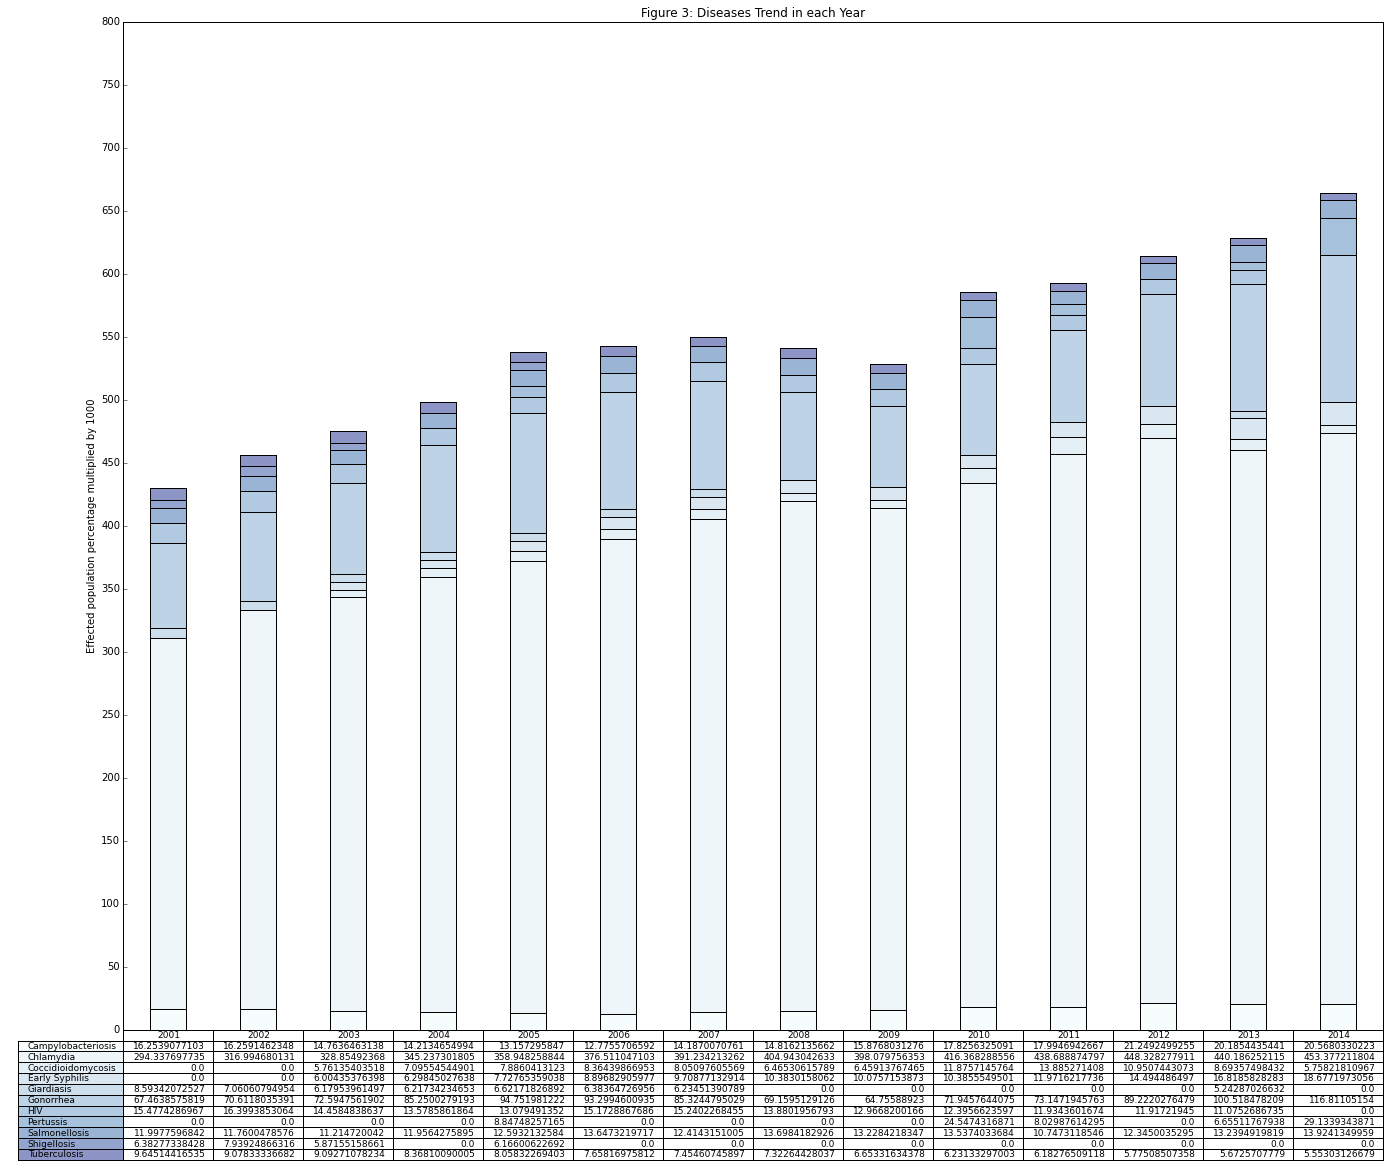

In [8]:
#print df_pivot
#df_pivot.div(df_pivot.sum(axis=1), axis=0)
#Remove the year column
df_pivot_std = df_pivot [df_pivot.columns.values[1:]]

#Standardize the values
df_pivot_std = df_pivot_std.div(df_pivot_std.sum(axis=1), axis=0)

#Add the year back to the standardized data frame
df_pivot_std['year'] = df_pivot['year']
#print df_pivot
#print df_pivot_std 

data = [list(df_pivot[i]) for i in df_pivot.columns.values[1:]]

#data = map(list,df_pivot[df_pivot.columns.values[1:]].values)
#print data

columns = (df_pivot[df_pivot.columns.values[0]].values)
#print columns

rows = df_pivot.columns.values[1:]




#values = np.arange(0, 850, 50)
#value_increment = 50

values = np.arange(0, 100, 1)
value_increment = 1

#print values

colors = plt.cm.BuPu(np.linspace(0, 0.5, len(rows)))
#colors = color_sequence

n_rows = len(data)
#print data[0]

index = np.arange(len(columns)) + 0.3
bar_width = 0.4

fig, ax = plt.subplots(1, 1, figsize=(25, 20))

#plt.xlim(2001, 2014)
#plt.ylim(0, 500)
ax.get_xaxis().tick_bottom()
ax.get_yaxis().tick_left()


# Initialize the vertical-offset for the stacked bar chart.
y_offset = np.array([0.0] * len(columns))

# Plot bars and create text labels for the table
cell_text = []

for row in range(n_rows):
    plt.bar(index, data[row], bar_width, bottom=y_offset, color=colors[row])
    y_offset = y_offset + data[row]
    #cell_text.append(['%1.1f' % (x/1000.0) for x in y_offset])
    #cell_text.append(['%1.1f' % (x/1000.0) for x in y_offset])
# Reverse colors and text labels to display the last value at the top.
colors = list(reversed(colors[::-1]))
#print colors
cell_text.reverse()

# Add a table at the bottom of the axes
the_table = plt.table(cellText=data,
                      rowLabels=rows,
                      rowColours=colors,
                      colLabels=columns,
                      loc='bottom',fontsize=25)

# Adjust layout to make room for the table:
plt.subplots_adjust(left=0.2, bottom=0.2)

plt.ylabel('Effected population percentage multiplied by 1000')
#plt.yticks(values * value_increment, ['%d' % val for val in values])
plt.yticks(np.arange(0, 850, 50))
plt.xticks([])
plt.title('Figure 3: Diseases Trend in each Year')

plt.show()

#####Figure:3 Analysis
From the above bar chart plot, the percentage of population effected by all the diseases is always on the increasing mode (except in the year 2009). Also we can see that Chlamydia and Gonorrhea effected most of the population in all the years.

####5.2 Bar chart - 2
We will plot standardized bar chart (of Figure-3).

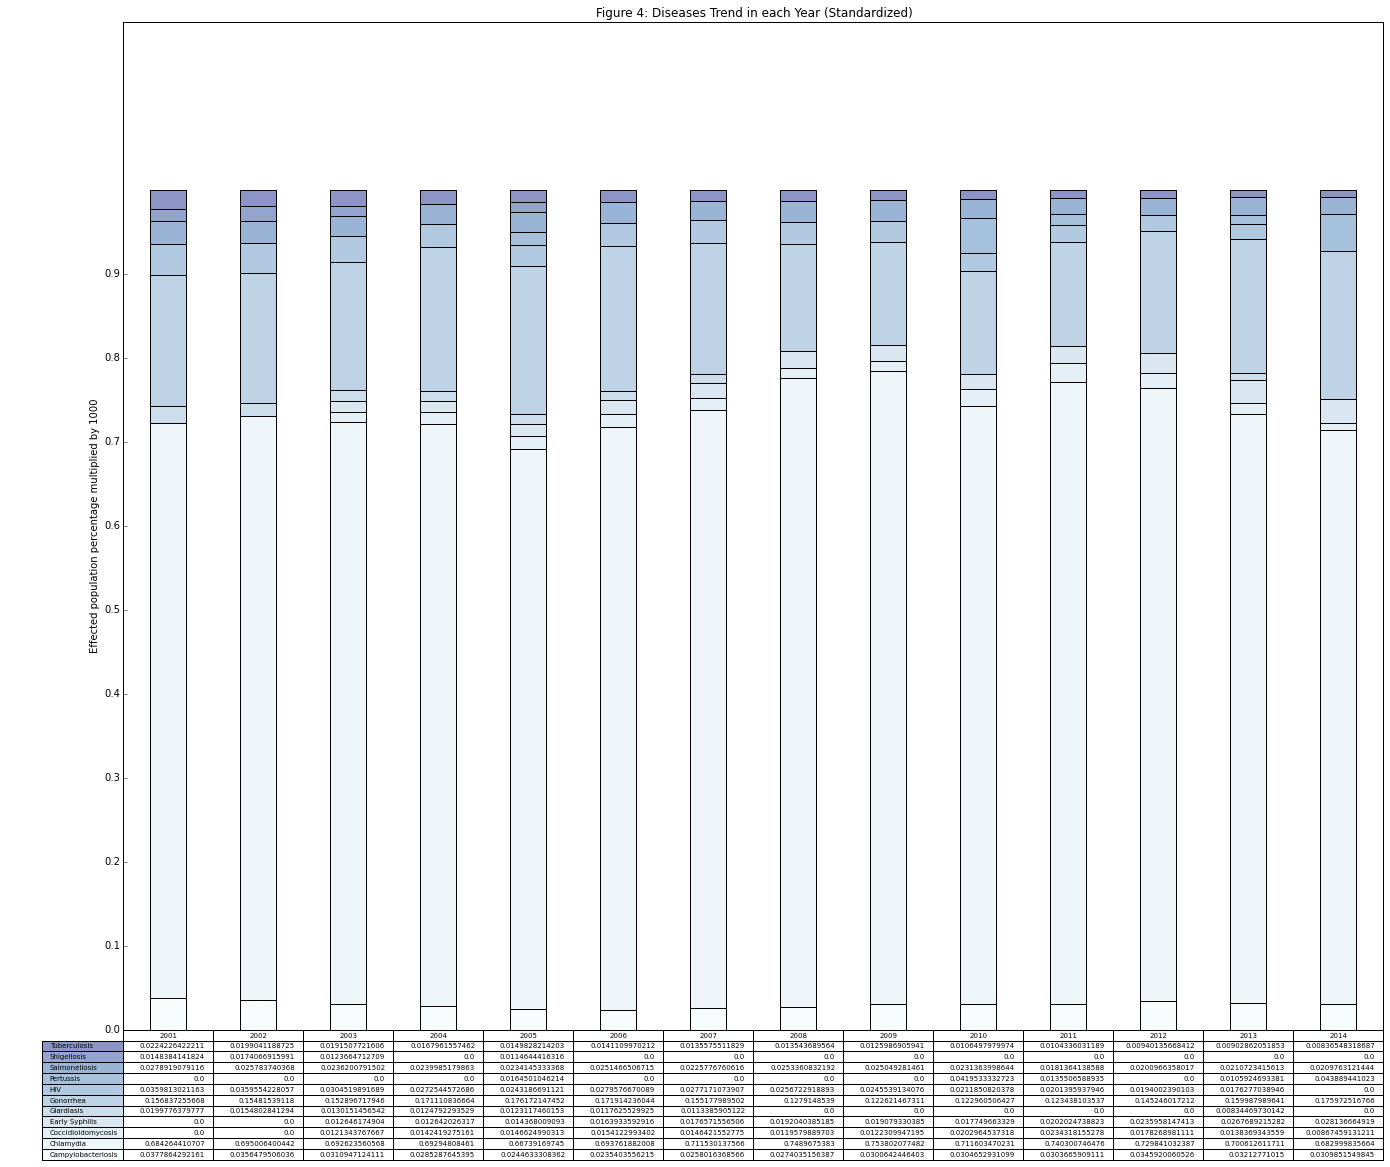

In [9]:
data = [list(df_pivot_std[i]) for i in df_pivot_std.columns.values[0:-1]]

#data_sum = map(list, df_pivot[df_pivot.columns.values[1:]].values)

#data_sum = [np.sum(j) for j in data_sum]
 



#data = map(list,df_pivot[df_pivot.columns.values[1:]].values)
 

columns = (df_pivot[df_pivot.columns.values[0]].values)
#print columns

#rows = df_pivot.columns.values[1:]

#print rows
rows = list(reversed(np.array(rows)))
#values = np.arange(0, 850, 50)
#value_increment = 50

values = np.arange(0, 1, 0.1)
value_increment = 0.1

#print values

colors = plt.cm.BuPu(np.linspace(0, 0.5, len(rows)))
#colors = color_sequence

n_rows = len(data)


index = np.arange(len(columns)) + 0.3
bar_width = 0.4

fig, ax = plt.subplots(1, 1, figsize=(25, 20))

#plt.xlim(2001, 2014)
#plt.ylim(0, 500)
ax.get_xaxis().tick_bottom()
ax.get_yaxis().tick_left()


# Initialize the vertical-offset for the stacked bar chart.
y_offset = np.array([0.0] * len(columns))

# Plot bars and create text labels for the table
cell_text = []

for row in range(n_rows):
    plt.bar(index, data[row], bar_width, bottom=y_offset, color=colors[row])
    y_offset = y_offset + data[row]
    #cell_text.append(['%1.1f' % (x/1000.0) for x in y_offset])
    #cell_text.append(['%1.1f' % (x/1000.0) for x in y_offset])
# Reverse colors and text labels to display the last value at the top.
colors = colors[::-1]
#cell_text.reverse()
data.reverse()
# Add a table at the bottom of the axes
the_table = plt.table(cellText=data,
                      rowLabels=rows,
                      rowColours=colors,
                      colLabels=columns,
                      loc='bottom',fontsize=25)

# Adjust layout to make room for the table:
plt.subplots_adjust(left=0.2, bottom=0.2)

plt.ylabel('Effected population percentage multiplied by 1000')
#plt.yticks(values * value_increment, ['%d' % val for val in values])
plt.yticks(np.arange(0, 1, 0.1))
plt.xticks([])
plt.title('Figure 4: Diseases Trend in each Year (Standardized)')

plt.show()


#####Figure:4 Analysis
The bar chart in Figure-4 represents the percentage of effect of a disease (relative to other diseases) in a given year. We considered only 11 diseases, since these 11 diseases have effected at least 2000 people in at least one year (between 2001 and 2004). 

This bar chart shows that in 2009, approximately 75% of the disease effected people were effected by Chlamydia also. While the over all disease effected population is low in 2009 (when compared to the years between 2006 and 2014), the effect of Chlamydia is high in 2009. Had this disease been controlled in 2009, the disease effected population would have further decreased. As per the data in the table (displayed below the graph), in 2014 the Chlamydia disease's effect (relative disease effect) has decreased from 69.67% (in 2013) to 67.38% (in 2014). The reason for this decrease is because the relative effect of Gonorrhea disease has increased from 15.9% (in 2013) to 17.3% (in 2014). 

#### Conclusion - 2:
The Figure 4, clearly indicates that the following 2 diseases have effected most of the population, when compared to all other diseases. 
1. Chlamydia
2. Gonorrhea

If the effect of these diseases is controlled (through reaserch/drugs/public awareness), then there will be a significant decrease in the over all disease rate. 

<a id='gender'></a>
###6. Analysis of Diseases trend in men and women
Next, we will try to find answers to the following questions:
1. Is there any association between gender and getting a disease? Does this association change over the years (2001 to 2014)?
2. For the following diseases, is there any association between gender and the disease? 

  * Chlamydia
  * Gonorrhea
  * Pertussis
  * Campylobacteriosis
  * Early Syphilis
  * Salmonellosis
  * Coccidioidomycosis
  * Tuberculosis
  * Giardiasis
  * Shigellosis
  * HIV

To answer the first question we will get the percentage of men and women effected by all diseases in each year, and plot a bar chart (segmented by gender) in each year. This bar chart will be standardized, so that we can analyze the diseases (over all diseases) trend in men and women (over the years 2001 to 2014). 

To answer the second question, we will get the percentage of men and women effected by the 11 listed diseases, irrespective of the year. In other words, we will sum the men's and women's population effected by these diseases in all the years (group by the 11 diseases and by gender). This data will be used to plot the bar charts.




####6.1 Bar chart - 1
We have to sum the "count" variable's data group by sex (only for "Male" and "Female" values), and "year". The **disease_df** data frame contains all the diseases information. Let us display a sample records from this data frame.

In [10]:
disease_df.head()

disease   county  year     sex  count  population   rate
42  Amebiasis  Alameda  2001   Total     16     1466038  1.091
43  Amebiasis  Alameda  2001  Female      7      746829  0.937
44  Amebiasis  Alameda  2001    Male      9      719209  1.251
45  Amebiasis  Alameda  2002   Total      9     1468943  0.613
46  Amebiasis  Alameda  2002  Female      4      748222  0.535

In [11]:
df_year_gender = disease_df[disease_df['sex'] != 'Total']
df_year_gender = df_year_gender.groupby(['year','sex'])['count'].sum()
df_year_gender = df_year_gender.reset_index()

df_year_gender = df_year_gender.pivot('year','sex','count')
df_year_gender = df_year_gender.reset_index()
df_year_gender =  df_year_gender[['year','Male','Female']]
df_year_gender['Total'] = df_year_gender['Male'] + df_year_gender['Female']
df_year_gender['Male_percent'] = df_year_gender['Male'] / df_year_gender['Total'] * 100
df_year_gender['Female_percent'] = df_year_gender['Female'] / df_year_gender['Total'] * 100

#df_year_gender.index.names = ['Index']
#print df_year_gender.head() 
#df_year_gender = df_year_gender.reset_index()


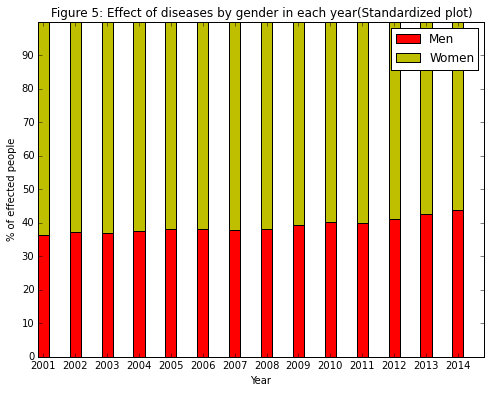

In [12]:
fig, ax = plt.subplots(nrows=1, ncols = 1, figsize=(8, 6))
N = 14
menMeans = tuple(df_year_gender['Male_percent'])
womenMeans = tuple(df_year_gender['Female_percent'])

ind = np.arange(N)    # the x locations for the groups
width = 0.35       # the width of the bars: can also be len(x) sequence

p1 = plt.bar(ind, menMeans, width, color='r')
#p2 = plt.bar(ind, womenMeans, width, color='y',
#             bottom=menMeans)

p2 = plt.bar(ind, womenMeans, width, color='y',
             bottom=menMeans)


plt.ylabel('% of effected people')
plt.xlabel('Year')
plt.title('Figure 5: Effect of diseases by gender in each year(Standardized plot)')
plt.xticks(ind + width/2., tuple(df_year_gender['year']))
plt.yticks(np.arange(0, 100, 10))
plt.legend((p1[0], p2[0]), ('Men', 'Women'))

plt.show()


####6.2 Bar chart - 2
We will plot non-standardized version of Figure 5 barplot

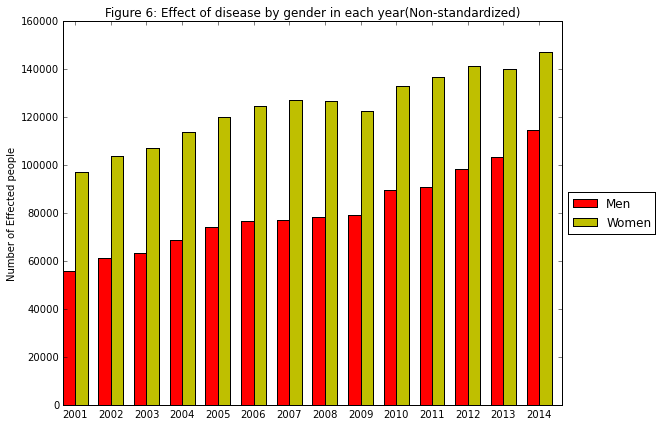

In [13]:
fig, ax = plt.subplots(nrows=1, ncols = 1, figsize=(8, 6))
N = 14
menMeans = tuple(df_year_gender['Male'])
womenMeans = tuple(df_year_gender['Female'])


ind = np.arange(N)    # the x locations for the groups
width = 0.35       # the width of the bars: can also be len(x) sequence
rects1 = ax.bar(ind, menMeans, width, color='r')
rects2 = ax.bar(ind + width, womenMeans, width, color='y')


ax.set_ylabel('Number of Effected people')
ax.set_title('Figure 6: Effect of disease by gender in each year(Non-standardized)')
ax.set_xticks(ind + width)
ax.set_xticklabels(tuple(df_year_gender['year']))
 
ax.legend((rects1[0], rects2[0]), ('Men', 'Women'), loc='center left', bbox_to_anchor=(1, 0.5))

fig.tight_layout() 
plt.show()

####6.3 Analysis
Figure 6 shows an interesting trend. It shows that the number of disease effected men and women have  increased consistently (except in the year 2009, we see a slight dip in the disease effected women population). 

From figure 5, we can conclude that Women are more prone to diseases than men, although the disease effect on both the genders is growing consistently. In other words, the probability that men would get a disease is certainly lesser than the probability that a women would get a disease.

From Figure 6, we can see that more women are getting effected than men in every year. This might be due to the following 2 reasons:

* Women population is much greater than men's population 

(or)

* The probability of getting most of the diseases is high in women 

Let us get how the population is divided between men and women


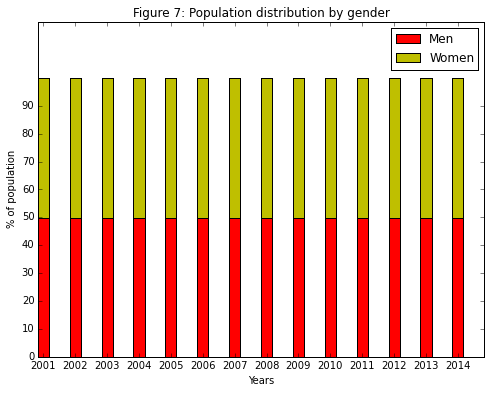

sex  year      Female        Male       Total  Male_percent  Female_percent
0    2001   901718740   893049664  1794768404     49.758490       50.241510
1    2002   912897128   904000188  1816897368     49.755160       50.244837
2    2003   924763996   915567224  1840331272     49.750131       50.249866
3    2004   934409008   924841996  1859251004     49.742719       50.257281
4    2005   940594252   930762872  1871357176     49.737318       50.262679
5    2006   965682843   955507267  1921190110     49.735175       50.264825
6    2007  1010567635   999933990  2010501570     49.735549       50.264454
7    2008  1037489768  1026573352  2064063120     49.735560       50.264440
8    2009  1062139710  1051377711  2113517421     49.745401       50.254599
9    2010  1125165000  1113521340  2238686340     49.739944       50.260056
10   2011  1227268510  1214923645  2442192090     49.747260       50.252743
11   2012  1236824875  1224697305  2461522180     49.753657       50.246343
12   2013  1246527620  1234269985  2480797605     49.752950       50.247050
13   2014  1257548890  1245048220  2502597110     49.750246       50.249754

In [14]:
populations = disease_df.groupby(['year','sex'])['population'].sum().reset_index()
populations = populations.pivot('year','sex','population').reset_index()
populations['Male_percent'] = populations['Male'] / populations['Total'] * 100
populations['Female_percent'] = populations['Female'] / populations['Total'] * 100

#Plot the histogram
fig, ax = plt.subplots(nrows=1, ncols = 1, figsize=(8, 6))
N = 14 #years

menMeans = tuple(populations['Male_percent'])
womenMeans = tuple(populations['Female_percent'])

ind = np.arange(N)    # the x locations for the groups
width = 0.35       # the width of the bars: can also be len(x) sequence

p1 = plt.bar(ind, menMeans, width, color='r')
#p2 = plt.bar(ind, womenMeans, width, color='y',
#             bottom=menMeans)

p2 = plt.bar(ind, womenMeans, width, color='y',
             bottom=menMeans)


plt.ylabel('% of population')
plt.xlabel('Years')
plt.title('Figure 7: Population distribution by gender')
plt.xticks(ind + width/2., tuple(populations['year']))
plt.yticks(np.arange(0, 100, 10))
plt.legend((p1[0], p2[0]), ('Men', 'Women'))

plt.show()

#df_gender_disease

populations

The above table and figure 7 show that the population is almost equally divided between men and women (in all the years). 

Let us find the probability of men or women given the disease (top 11 diseases)

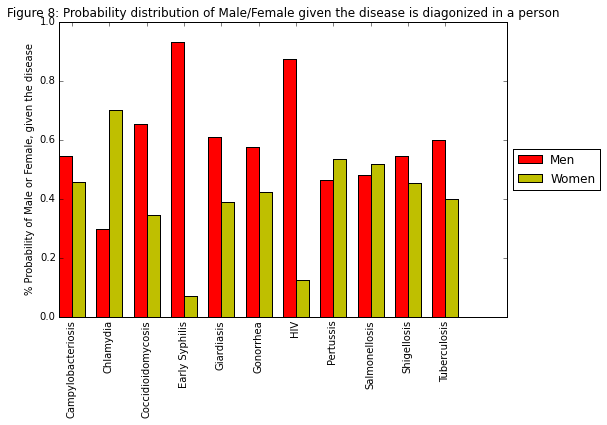

sex             disease   Female    Male  Prob_of_Female_given_the_disease  \
0    Campylobacteriosis    37898   45222                          0.455943   
1             Chlamydia  1393206  590360                          0.702374   
2    Coccidioidomycosis    13869   26415                          0.344281   
3        Early Syphilis     3596   48049                          0.069629   
4            Giardiasis    11278   17663                          0.389689   
5             Gonorrhea   179043  243506                          0.423721   
6                   HIV     9186   63470                          0.126431   
7             Pertussis    20260   17546                          0.535894   
8         Salmonellosis    33006   30806                          0.517238   
9           Shigellosis    10097   12172                          0.453411   
10         Tuberculosis    14947   22468                          0.399492   

sex  Prob_of_Male_given_the_disease  
0                          0.544057  
1                          0.297626  
2                          0.655719  
3                          0.930371  
4                          0.610311  
5                          0.576279  
6                          0.873569  
7                          0.464106  
8                          0.482762  
9                          0.546589  
10                         0.600508

In [15]:
diseases = list(u['disease'])
#disease_df_state[disease_df_state['disease'].isin(diseases)].groupby(['disease','sex'])['rate'].mean()
#disease_df_state[disease_df_state['disease'].isin(diseases)]
#diseases

df_gender_disease = disease_df_state[disease_df_state['disease'].isin(diseases)]
df_gender_disease = df_gender_disease[df_gender_disease['sex'] != 'Total']
df_gender_disease = df_gender_disease.groupby(['disease','sex'])['count'].sum().reset_index()
df_gender_disease = df_gender_disease.pivot('disease','sex','count').reset_index()
df_gender_disease['Prob_of_Female_given_the_disease'] = df_gender_disease['Female']/(df_gender_disease['Female'] +  df_gender_disease['Male'])
df_gender_disease['Prob_of_Male_given_the_disease'] = df_gender_disease['Male']/(df_gender_disease['Female'] +  df_gender_disease['Male'])
#total_diseases = df_gender_disease['Male'].sum() + df_gender_disease['Female'].sum()

#Plot the histogram




fig, ax = plt.subplots(nrows=1, ncols = 1, figsize=(8, 6))
N = 11 #11 diseases

menMeans = tuple(df_gender_disease['Prob_of_Male_given_the_disease'])
womenMeans = tuple(df_gender_disease['Prob_of_Female_given_the_disease'])


ind = np.arange(N)    # the x locations for the groups
width = 0.35       # the width of the bars: can also be len(x) sequence
rects1 = ax.bar(ind, menMeans, width, color='r')
rects2 = ax.bar(ind + width, womenMeans, width, color='y')


ax.set_ylabel('% Probability of Male or Female, given the disease')
ax.set_title('Figure 8: Probability distribution of Male/Female given the disease is diagonized in a person')
ax.set_xticks(ind + width)
ax.set_xticklabels(tuple(df_gender_disease['disease']),rotation='vertical')
 
ax.legend((rects1[0], rects2[0]), ('Men', 'Women'), loc='center left', bbox_to_anchor=(1, 0.5))

fig.tight_layout() 
plt.show()


df_gender_disease

The above table and figure 8 show the conditional probability of Male (or Female) given the disease. That is, the columns Prob_of_Female_given_the_disease is nothing but $P(Female | disease)$ and Prob_of_Male_given_the_disease is $P(Male | disease)$. 

In Figure 8 and also the above table, we can clearly observe that except for 'Chlamydia' disease, all other diseases occur mostly in men. For instance if 100 people are diagonized with Chlamydia, approximately 70 people are women and 30 are men. For the remaining diseases the probability that the diseased person being men is high or approximately same as women. 

Using the figures 6, 7 and 8, we can conclude the following:

####Conclusion 3:
In Figure 6, we can see that more women population is getting effected by diseases every year, when compared to the male population. We also confirmed that both men and women are equally present in the population (see figure 7). From Figure 8, we can see that except Chlamydia, all other diseases occur mostly in male or equally in both male and female. Hence we can conclude that the reason for more diseases effecting women is because of the significant effect of Chlamydia disease among women. If this disease is controlled in Women, then the number of disease effected women can be drastically reduced.

**NOTE: The above table displays the conditional probabilities of the person being male or female, given that a person is diagonized with a disease. This is not the same as the disease rate. As per figure 1, the top 2 diseases that have consistently effected California population are 	Chlamydia and Gonorrhea. As per above table Gonorrhea occurs more in Men than women, while Chlamydia effects more women than men. **

<a id='top_diseases'></a>
###7. Top diseases analysis
From now onwards, we will confine our analysis to the following two diseases only. These two diseases have effected most of the population between 2001 and 2014. The effect of these two diseases, compared to the other diseases is very high:

* Chlamydia
* Gonorrhea

The following table will show you the probability of getting these two diseases, along with other top 9 diseases (we obtained top 11 diseases, by selecting the diseases that have effected at least 2000 people between 2001 and 2014, in at least 1 year).




In [16]:
diseases = list(u['disease'])
top_prob = disease_df_state[(disease_df_state['sex'] == 'Total') & disease_df_state['disease'].isin(list(diseases))]
top_prob = top_prob.groupby(['disease'])['rate'].mean()/1000 
top_prob = DataFrame(top_prob.reset_index())
top_prob = top_prob.rename(columns={'rate':'prob_percent'})
top_prob.sort('prob_percent',ascending=[0])

disease  prob_percent
1            Chlamydia      0.386578
5            Gonorrhea      0.082490
0   Campylobacteriosis      0.016438
6                  HIV      0.014267
8        Salmonellosis      0.012593
3       Early Syphilis      0.009955
2   Coccidioidomycosis      0.007870
10        Tuberculosis      0.007339
7            Pertussis      0.007274
4           Giardiasis      0.005820
9          Shigellosis      0.004493

Hence the probability of getting Chlamydia is 0.386578%, and getting Gonorrhea is 0.08249%. All other diseases probability is much lesser when compared to Chlamydia. Also the disease Chlamydia occurs mostly in Women, and Gonorrhea occurs mostly in men. Coincidentally these two diseases are STD (Sexually Transmitted Diseases).

Let us create **top_diseases** data set, which has the rows related to Chlamydia and Gonorrhea

In [17]:
top_diseases = disease_df[disease_df['disease'].isin(['Chlamydia','Gonorrhea'])]
#top_diseases

###7.1 Effect of Chlamydia and Gonorrhea in various counties of California

We will answer the following questions in this analysis:
1. Which county(s) have the most Chlamydia and Gonorrhea cases for the years between 2001 and 2014?

####7.1.1 Chalmydia effect in counties
The following code plots a bar chart for the number of people effected in each counties of CA by the Chalmydia disease (between the years 2001 and 2014)

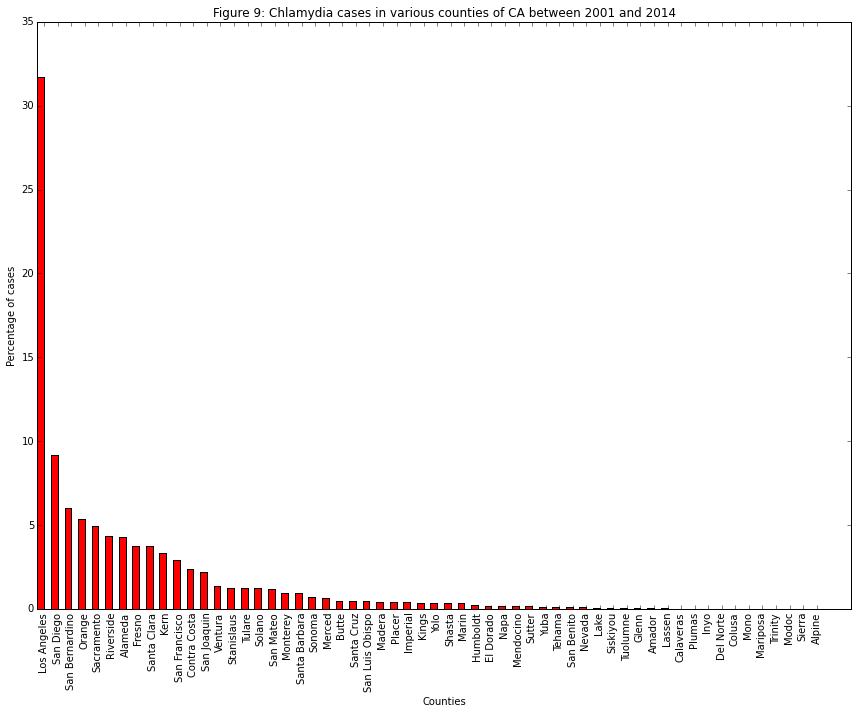

In [18]:
disease_Chlamydia= top_diseases[top_diseases['disease'] == 'Chlamydia']
disease_Chlamydia = disease_Chlamydia.groupby(['county'])['count'].sum().reset_index()
cnt = disease_Chlamydia['count'].sum()
disease_Chlamydia['proportion_percentage'] = (disease_Chlamydia['count'] / float(cnt)) * 100

disease_Chlamydia = disease_Chlamydia.sort('count',ascending=0)

#Plot the bar chart

#fig, ax = plt.subplots(nrows=1, ncols = 1, figsize=(8, 6))
fig, ax = plt.subplots(nrows=1, ncols = 1, figsize=(12,10))
N = 58 #counties

Means = tuple(disease_Chlamydia['proportion_percentage'])



ind = np.arange(N)    # the x locations for the groups
width = 0.5       # the width of the bars: can also be len(x) sequence
rects1 = ax.bar(ind, Means, width, color='r')
#rects2 = ax.bar(ind + width, womenMeans, width, color='y')


ax.set_ylabel('Percentage of cases')
ax.set_xlabel('Counties')

ax.set_title('Figure 9: Chlamydia cases in various counties of CA between 2001 and 2014')
ax.set_xticks(ind + width)
ax.set_xticklabels(tuple(disease_Chlamydia['county']),rotation='vertical')
 
#ax.legend((rects1[0], rects2[0]), ('Men', 'Women'), loc='center left', bbox_to_anchor=(1, 0.5))

fig.tight_layout() 
plt.show()





The above plot shows that Los Angles county has most of the Chlamydia cases, followed by San Diego etc. But this proportion is for all the years. We need further analysis, if Los Angles always tops the trend in each year.

####7.1.2 Plotting dot plot for Chalmydia disease's effect in various counties, broken by years
We will plot a dot plot to check if there is any difference in the Chalmydia's effect in various counties in the years between 2001 and 2014

In [19]:
disease_Chlamydia= top_diseases[top_diseases['disease'] == 'Chlamydia']
disease_Chlamydia = disease_Chlamydia.groupby(['county','year'])['count'].sum().reset_index()

cnt = disease_Chlamydia.groupby(['year'])['count'].sum()
cnt = cnt.reset_index()
#cnt.set_index('year')
#disease_Chlamydia = disease_Chlamydia.set_index('year')

#print disease_Chlamydia


#disease_Chlamydia = pd.concat([disease_Chlamydia, cnt], axis=1, join='inner')

disease_Chlamydia = pd.merge(disease_Chlamydia, cnt, how='inner', on=['year'])
disease_Chlamydia.columns = ['county','year','Chlamydia_count','all_diseases_count']
#print disease_Chlamydia

#disease_Chlamydia = disease_Chlamydia.T.drop_duplicates()

#disease_Chlamydia = disease_Chlamydia.T

#disease_Chlamydia.columns = ['county','year','Chlamydia_count','all_diseases_count']
disease_Chlamydia['Chlamydia_percent'] = disease_Chlamydia['Chlamydia_count']/disease_Chlamydia['all_diseases_count'] * 100
disease_Chlamydia = disease_Chlamydia.pivot('year','county','Chlamydia_percent').reset_index()
#disease_Chlamydia
#disease_Chlamydia.sum(axis=1)

#sum(axis=None, skipna=None, level=None, numeric_only=None, **kwargs)
#print disease_Chlamydia

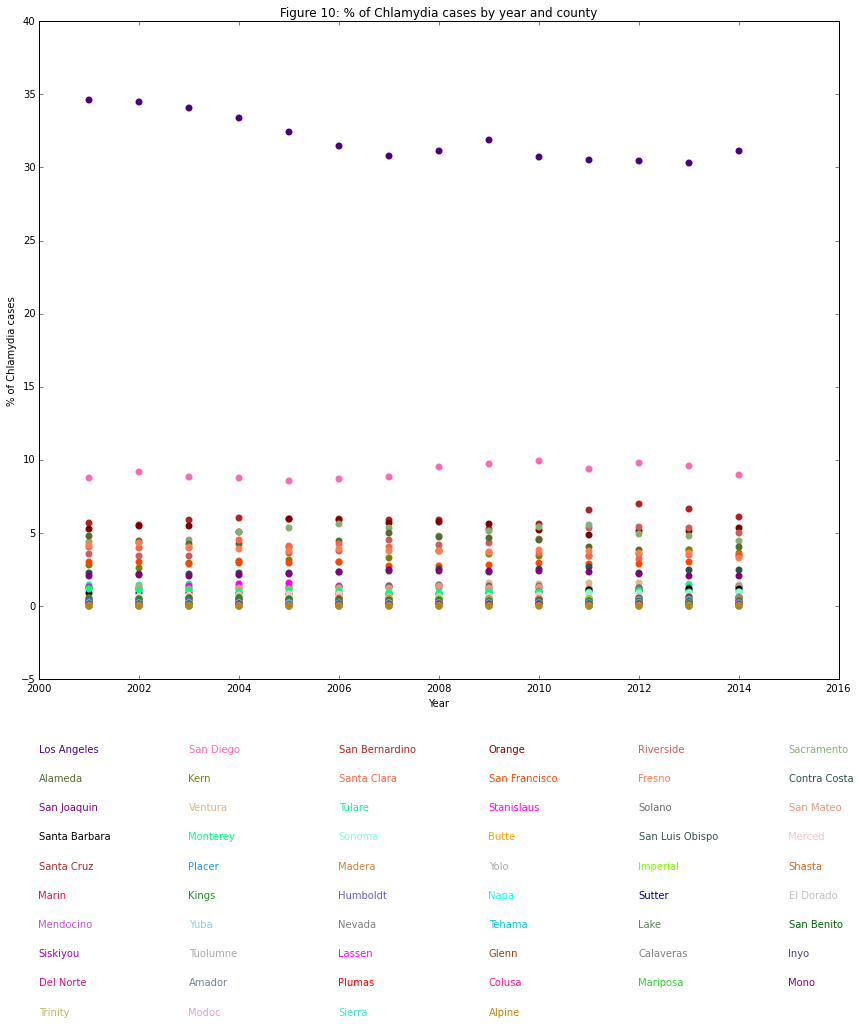

In [20]:
N = 58
colors= ['indigo',  'hotpink', 'firebrick','maroon', 'indianred',
 'sage',  'darkolivegreen', 'olive',
   'tomato', 'orangered', 'coral', 'darkslategrey',
 'purple', 'burlywood', 'mediumspringgreen','fuchsia', 
 'dimgray', 'darksalmon','black' , 'springgreen', 'aquamarine', 'orange', 'darkslategray',
 'pink',
         'brown', 'dodgerblue', 'peru', 'darkgrey', 'lawngreen',
 'chocolate', 'crimson', 'forestgreen', 'slateblue',  'cyan', 'darkblue', 'silver', 'mediumorchid',
 'skyblue', 'gray', 'darkturquoise', 'darksage',
         
         
         'darkgreen', 'darkviolet', 'darkgray',
 'magenta', 'saddlebrown', 'grey', 'darkslateblue',  'mediumvioletred', 'slategrey',
 'red', 'deeppink', 'limegreen', 'darkmagenta', 'darkkhaki', 'plum', 'turquoise',
  'darkgoldenrod', 
         
         
         'lavender', 'gold', 'yellowgreen', 'sandybrown', 'thistle',
 'violet', 'navy', 'magenta', 'dimgrey', 'tan', 'rosybrown', 'olivedrab', 'blue',  'cornflowerblue',
 'linen', 'mintcream', 'powderblue', 'seagreen', 'darkkhaki',  'sienna', 'mediumblue', 'royalblue',
 'green', 'mediumpurple', 'midnightblue', 'cornsilk', 'paleturquoise', 'bisque', 'slategray', 'darkcyan',
 'khaki', 'wheat', 'teal', 'darkorchid', 'deepskyblue', 'salmon', 'darkred', 'steelblue', 'palevioletred',
 'lightslategray',  'lightgreen', 'orchid', 'gainsboro', 'mediumseagreen', 'lightgray', 'mediumturquoise',
 'darksage',  'cadetblue', 'lightyellow', 'lavenderblush', 'palegreen', 'greenyellow', 'aqua', 'lightsage', 'mediumslateblue',
 'darkorange', 'mediumaquamarine', 'peachpuff', 'beige', 'blueviolet',  'lightsteelblue', 'oldlace']


fig, ax = plt.subplots(nrows=1, ncols = 1, figsize=(12,10))

ind = np.arange(14)    # the x locations for the groups
width = 0.35       # the width of the bars: can also be len(x) sequence


ax.set_ylabel('% of Chlamydia cases')
ax.set_xlabel('Year')
ax.set_title('Figure 10: % of Chlamydia cases by year and county')
#ax.set_xticks(ind + width)
#ax.set_xticklabels(tuple(disease_Chlamydia['year']),rotation='vertical')
#ax.set_xticklabels(tuple(range(2001,2015)),rotation='vertical')
#ax.set_yticklabels(tuple(range(-5,45,5)),rotation='vertical')

u = disease_Chlamydia[disease_Chlamydia['year'] == 2014]
u = pd.melt(u,id_vars=['year']).sort('value', ascending = [0])
counties = u['county']


#counties = list(disease_Chlamydia.columns)[1:]
i = -10
j = 0
for rank, column in enumerate(counties):
    # Plot each line separately with its own color.
    #column_rec_name = column.replace('\n', '_').replace(' ', '_').lower()
    
    column_rec_name = column
    #df_pivot.year will just give the unique year values
    plt.scatter(disease_Chlamydia.year,
                    disease_Chlamydia[column_rec_name],
                    lw=2.5,
                    color=colors[rank])
    plt.text(2000+j, i, column, fontsize=10, color=colors[rank])
    
    j = (j+3) % 18
    if (j == 0):
        i = i - 2

   
fig.tight_layout() 
plt.show()


* The above dot plot clearly indicates that the Los Angles county has the most of the registered Chlamydia cases in all the years. In fact of all the Chlamydia cases in the state (in any year between 2001 and 2014), at least 33% of the cases were registered in Los Angles. 
* San Diego is the next county that has most of the registered cases (approximately 9% to 10%)
* San Bernardino/Orange counties stand in the 3rd place (approximately 5%).

###Conclusion 4:
The effect of Chlamydia disease varies across different counties of CA, and the Los Angles's population and San Diego's are mostly effected by this disease (30% to 35% in Los Angles and 9% to 10% in San Diego).


####7.1.3 Gonorrhea's effect in counties
The following code plots a bar chart for the number of people effected in each counties of CA by the Gonorrhea disease (between the years 2001 and 2014)

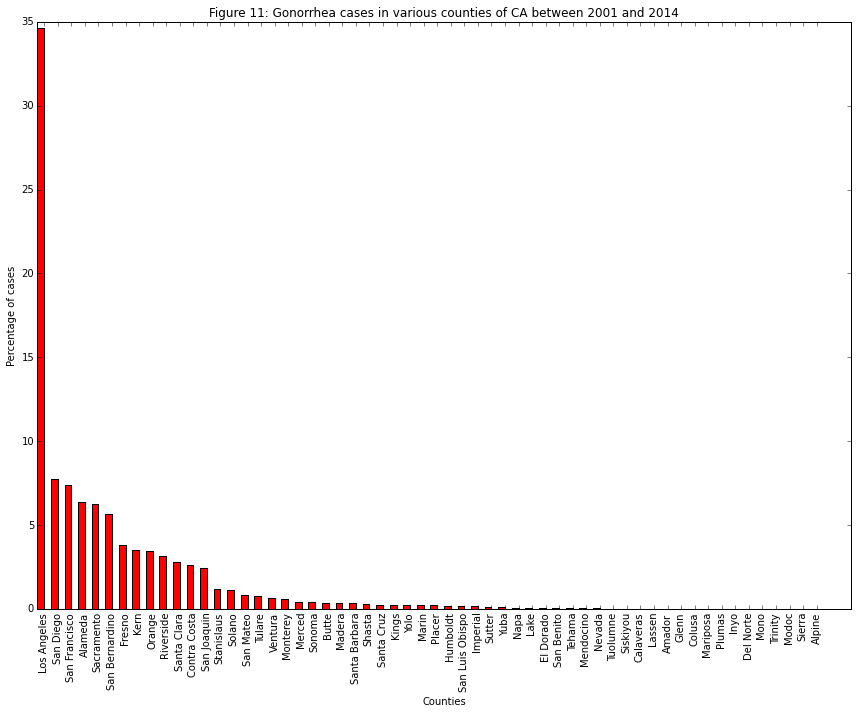

In [21]:
disease_Gonorrhea= top_diseases[top_diseases['disease'] == 'Gonorrhea']
disease_Gonorrhea = disease_Gonorrhea.groupby(['county'])['count'].sum().reset_index()
cnt = disease_Gonorrhea['count'].sum()
disease_Gonorrhea['proportion_percentage'] = (disease_Gonorrhea['count'] / float(cnt)) * 100

disease_Gonorrhea = disease_Gonorrhea.sort('count',ascending=0)

#Plot the bar chart

#fig, ax = plt.subplots(nrows=1, ncols = 1, figsize=(8, 6))
fig, ax = plt.subplots(nrows=1, ncols = 1, figsize=(12,10))
N = 58 #counties

Means = tuple(disease_Gonorrhea['proportion_percentage'])



ind = np.arange(N)    # the x locations for the groups
width = 0.5       # the width of the bars: can also be len(x) sequence
rects1 = ax.bar(ind, Means, width, color='r')
#rects2 = ax.bar(ind + width, womenMeans, width, color='y')


ax.set_ylabel('Percentage of cases')
ax.set_xlabel('Counties')

ax.set_title('Figure 11: Gonorrhea cases in various counties of CA between 2001 and 2014')
ax.set_xticks(ind + width)
ax.set_xticklabels(tuple(disease_Gonorrhea['county']),rotation='vertical')
 
#ax.legend((rects1[0], rects2[0]), ('Men', 'Women'), loc='center left', bbox_to_anchor=(1, 0.5))

fig.tight_layout() 
plt.show()



####7.1.4 Plotting dot plot for Gonorrhea disease's effect in various counties, broken by years

We will plot a dot plot to check if there is any difference in the Gonorrhea's effect in various counties in the years between 2001 and 2014

In [22]:
disease_Gonorrhea= top_diseases[top_diseases['disease'] == 'Gonorrhea']
disease_Gonorrhea = disease_Gonorrhea.groupby(['county','year'])['count'].sum().reset_index()

cnt = disease_Gonorrhea.groupby(['year'])['count'].sum()
cnt = cnt.reset_index()
#cnt.set_index('year')
#disease_Gonorrhea = disease_Gonorrhea.set_index('year')

#print disease_Gonorrhea


#disease_Gonorrhea = pd.concat([disease_Gonorrhea, cnt], axis=1, join='inner')

disease_Gonorrhea = pd.merge(disease_Gonorrhea, cnt, how='inner', on=['year'])
disease_Gonorrhea.columns = ['county','year','Gonorrhea_count','all_diseases_count']
#print disease_Gonorrhea

#disease_Gonorrhea = disease_Gonorrhea.T.drop_duplicates()

#disease_Gonorrhea = disease_Gonorrhea.T

#disease_Gonorrhea.columns = ['county','year','Gonorrhea_count','all_diseases_count']
disease_Gonorrhea['Gonorrhea_percent'] = disease_Gonorrhea['Gonorrhea_count']/disease_Gonorrhea['all_diseases_count'] * 100
disease_Gonorrhea = disease_Gonorrhea.pivot('year','county','Gonorrhea_percent').reset_index()
#disease_Gonorrhea
#disease_Gonorrhea.sum(axis=1)

#sum(axis=None, skipna=None, level=None, numeric_only=None, **kwargs)
#print disease_Gonorrhea

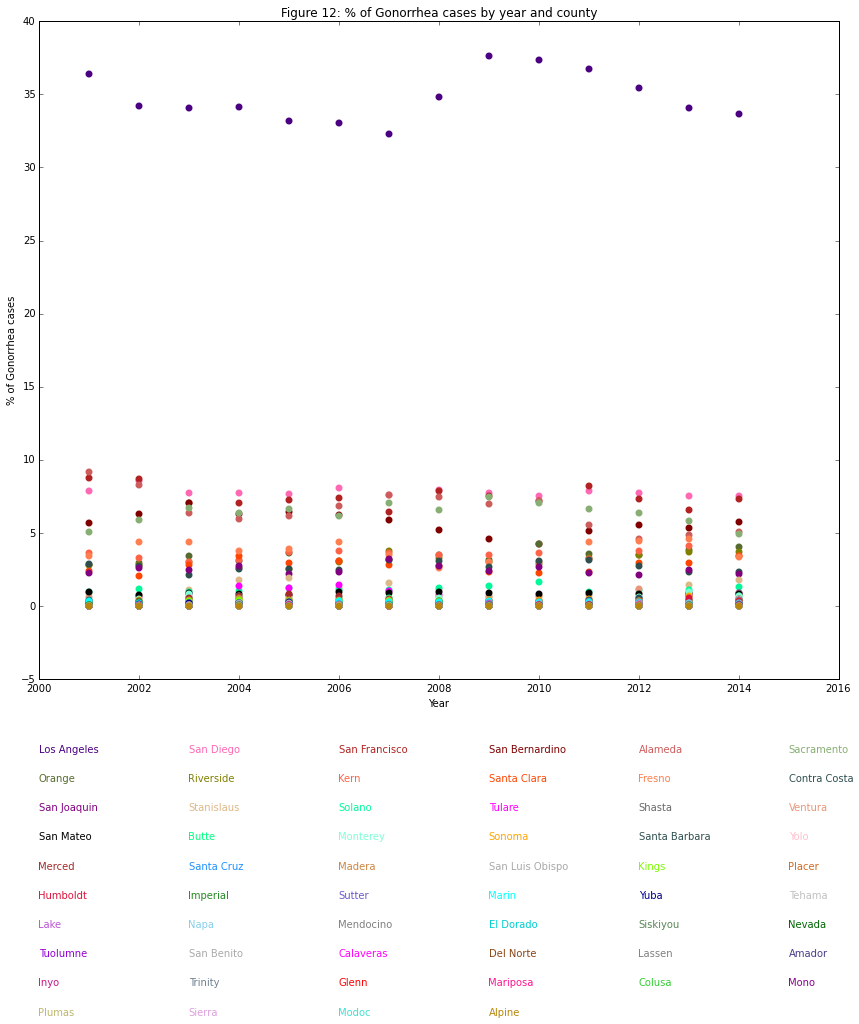

In [23]:
N = 58
colors= ['indigo',  'hotpink', 'firebrick','maroon', 'indianred',
 'sage',  'darkolivegreen', 'olive',
   'tomato', 'orangered', 'coral', 'darkslategrey',
 'purple', 'burlywood', 'mediumspringgreen','fuchsia', 
 'dimgray', 'darksalmon','black' , 'springgreen', 'aquamarine', 'orange', 'darkslategray',
 'pink',
         'brown', 'dodgerblue', 'peru', 'darkgrey', 'lawngreen',
 'chocolate', 'crimson', 'forestgreen', 'slateblue',  'cyan', 'darkblue', 'silver', 'mediumorchid',
 'skyblue', 'gray', 'darkturquoise', 'darksage',
         
         
         'darkgreen', 'darkviolet', 'darkgray',
 'magenta', 'saddlebrown', 'grey', 'darkslateblue',  'mediumvioletred', 'slategrey',
 'red', 'deeppink', 'limegreen', 'darkmagenta', 'darkkhaki', 'plum', 'turquoise',
  'darkgoldenrod', 
         
         
         'lavender', 'gold', 'yellowgreen', 'sandybrown', 'thistle',
 'violet', 'navy', 'magenta', 'dimgrey', 'tan', 'rosybrown', 'olivedrab', 'blue',  'cornflowerblue',
 'linen', 'mintcream', 'powderblue', 'seagreen', 'darkkhaki',  'sienna', 'mediumblue', 'royalblue',
 'green', 'mediumpurple', 'midnightblue', 'cornsilk', 'paleturquoise', 'bisque', 'slategray', 'darkcyan',
 'khaki', 'wheat', 'teal', 'darkorchid', 'deepskyblue', 'salmon', 'darkred', 'steelblue', 'palevioletred',
 'lightslategray',  'lightgreen', 'orchid', 'gainsboro', 'mediumseagreen', 'lightgray', 'mediumturquoise',
 'darksage',  'cadetblue', 'lightyellow', 'lavenderblush', 'palegreen', 'greenyellow', 'aqua', 'lightsage', 'mediumslateblue',
 'darkorange', 'mediumaquamarine', 'peachpuff', 'beige', 'blueviolet',  'lightsteelblue', 'oldlace']


fig, ax = plt.subplots(nrows=1, ncols = 1, figsize=(12,10))

ind = np.arange(14)    # the x locations for the groups
width = 0.35       # the width of the bars: can also be len(x) sequence


ax.set_ylabel('% of Gonorrhea cases')
ax.set_xlabel('Year')
ax.set_title('Figure 12: % of Gonorrhea cases by year and county')
#ax.set_xticks(ind + width)
#ax.set_xticklabels(tuple(disease_Gonorrhea['year']),rotation='vertical')
#ax.set_xticklabels(tuple(range(2001,2015)),rotation='vertical')
#ax.set_yticklabels(tuple(range(-5,45,5)),rotation='vertical')

u = disease_Gonorrhea[disease_Gonorrhea['year'] == 2014]
u = pd.melt(u,id_vars=['year']).sort('value', ascending = [0])
counties = u['county']


#counties = list(disease_Gonorrhea.columns)[1:]
i = -10
j = 0
for rank, column in enumerate(counties):
    # Plot each line separately with its own color.
    #column_rec_name = column.replace('\n', '_').replace(' ', '_').lower()
    
    column_rec_name = column
    #df_pivot.year will just give the unique year values
    plt.scatter(disease_Gonorrhea.year,
                    disease_Gonorrhea[column_rec_name],
                    lw=2.5,
                    color=colors[rank])
    plt.text(2000+j, i, column, fontsize=10, color=colors[rank])
    
    j = (j+3) % 18
    if (j == 0):
        i = i - 2

   
fig.tight_layout() 
plt.show()


* The above dot plot clearly indicates that the Los Angles county has the most of the registered Gonorrhea cases in all the years. In fact of all the Gonorrhea cases in the state (in any year between 2001 and 2014), at least 33% of the cases were registered in Los Angles. 
* San Diego is the next county that has most of the registered cases (approximately 8% to 10%)
* San bernardino/San Fransisco counties stand in the 3rd place (approximately 7%).

###Conclusion 5:
The effect of Gonorrhea disease also varies across different counties of CA, and the Los Angles's population and San Diego's are mostly effected by this disease (33% to 38% in Los Angles and 8% to 10% in San Diego). 


<a id='PCA'></a>
###8. Principal Component Analysis
We determined that Chlamydia and Gonorrhea are the top 2 disease that have effected most of the women and men respectively. We also determined that some counties have shown most of the Chlamydia and Gonorrhea cases in all the years. But is there any way we can group the counties based on these two diseases effect on men and women? This analysis can be performed by Principal Component Analysis (PCA). PCA will help us to reduce the data dimensionality, and transform the data to the vectors, which capture the maximum variance in the data. 

####8.1 Data preparation, standardization and transformation
We will prepare a data frame, which contains the number of effected men, number of effected women by Chlamydia and Gonorrhea, group by year and county. We will standardize the data, and perform PCA (Principal Component Analysis). The following code will perform the data standardization.

In [24]:
df = top_diseases[top_diseases['sex'] != 'Total']
s1=Series(df['disease'] + "-" + df["sex"],index=df.index)
s2=Series(df["county"] + "-" + df["year"].map(str) ,index=df.index)
#pd.merge(df, s, how='inner')
#disease_Chlamydia.columns = ['county','year','Chlamydia_count','all_diseases_count']

df = pd.concat([s1,s2,df], axis=1, join='inner', join_axes=None, ignore_index=False,
       keys=None, levels=None, names=None, verify_integrity=False)

del(df['disease'],df['year'],df['county'],df['population'],df['rate'],df['sex'])

df.columns=['disease-gender','county-year','count']
df_orig = df
df = df.pivot('county-year','disease-gender','count').reset_index()
df_counties = df['county-year']
df_county_year = df['county-year'] 
del(df['county-year'])
df_std = (df - df.mean())/df.std()
df_std.head()

disease-gender  Chlamydia-Female  Chlamydia-Male  Gonorrhea-Female  \
0                       0.459531        0.196711          1.507817   
1                       0.468371        0.196711          1.402245   
2                       0.480236        0.205093          1.058284   
3                       0.530256        0.256372          1.117881   
4                       0.511411        0.276587          1.463545   

disease-gender  Gonorrhea-Male  
0                     0.775480  
1                     0.749234  
2                     0.537078  
3                     0.691274  
4                     0.763450

####8.2 Performing Principal Component Analysis
The following code will perform PCA, shows the "Variance explained" by each of the eigen vectors

In [25]:
mlab_pca = mlabPCA(df_std)
print('Explained variance by each of the Principal components:',mlab_pca.fracs)

print('Eigen vectors:')
print(mlab_pca.Wt)

v1_x = mlab_pca.Wt[0,][0]
v1_y = mlab_pca.Wt[1,][0]

v2_x = mlab_pca.Wt[0,][1]
v2_y = mlab_pca.Wt[1,][1]

v3_x = mlab_pca.Wt[0,][2]
v3_y = mlab_pca.Wt[1,][2]

v4_x = mlab_pca.Wt[0,][3]
v4_y = mlab_pca.Wt[1,][3]



('Explained variance by each of the Principal components:', array([ 0.96360329,  0.02376139,  0.01145588,  0.00117944]))
Eigen vectors:
[[-0.50355018 -0.5039423  -0.49540448 -0.49704504]
 [ 0.26483288 -0.33330983  0.67475315 -0.60288995]
 [-0.55818788 -0.42961644  0.47674943  0.52589541]
 [-0.60392636  0.67110091  0.26831431 -0.33601184]]


We can see that the first eigen vector explains approximately 96% of the variance, the second eigen vector explains 2.37% of the variance, the other two eigen vectors explain the remaining variance. Since the first 2 eigen vectors explain approximately 98.7% of the variance, we will consider the first two eigen vectors. We will use these two vectors to transform the data to two axis (PC1, and PC2). PC1 is for principal component 1 and PC2 is for principal component 2. The following command shows the transformed data. We will consider the first 2 columns data only to plot the data (since these 2 columns correspond to the PC1 and PC2 transformation.

In [26]:


print(DataFrame(mlab_pca.Y).head())



          0         1         2         3
0 -1.462956  0.606009  0.785658 -0.001511
1 -1.402061  0.552938  0.716589 -0.026358
2 -1.136409  0.449104  0.430809 -0.048901
3 -1.293604  0.392510  0.490363 -0.080517
4 -1.501421  0.570504  0.694949  0.012925


####8.3 Plotting the transformed data to PC1 and PC2
The following code plots the transformed data to PC1 and PC2. This will also plot the Chlamydia-Male, Chlamydia-Female, Gonorrhea-Male, Gonorrhea-Female vectors also. These vectors will help us to identify the relative magnitude of diseases effect on each of the genders in various counties.

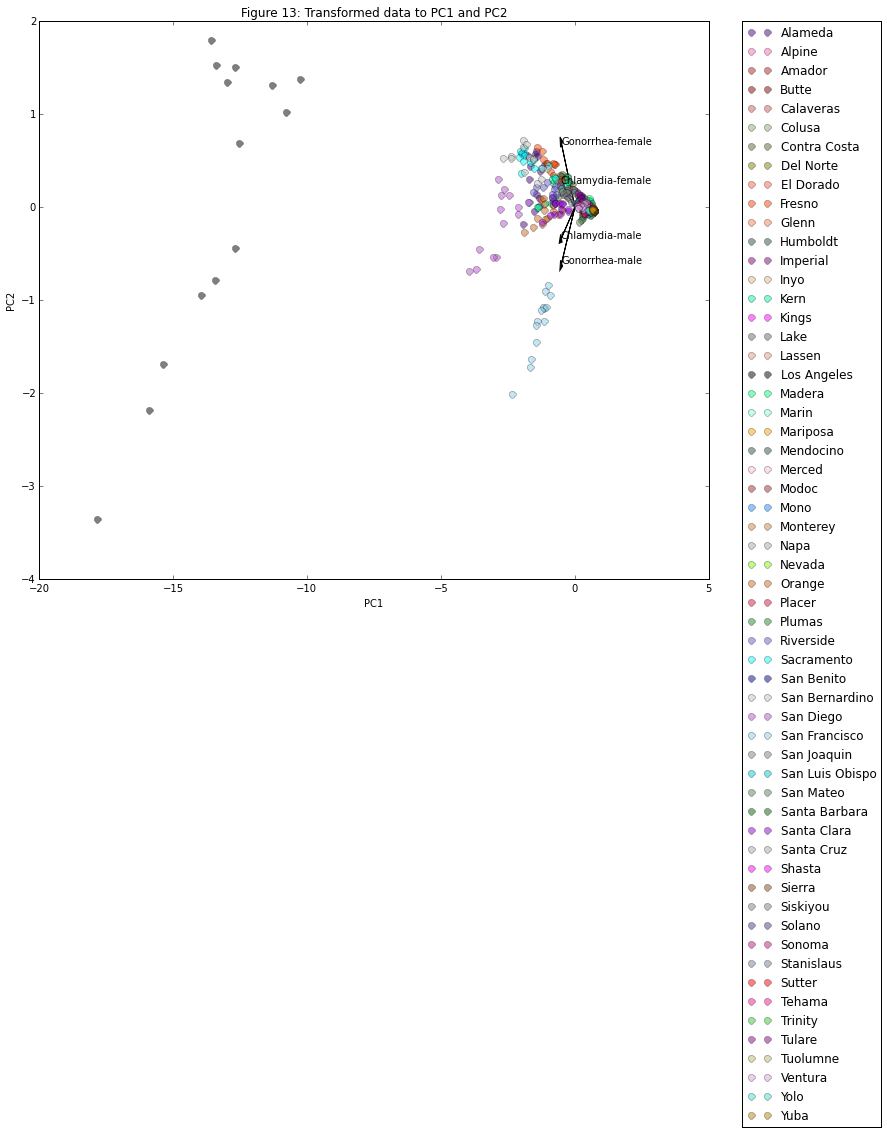

In [27]:
colors= ['indigo',  'hotpink', 'firebrick','maroon', 'indianred',
 'sage',  'darkolivegreen', 'olive',
   'tomato', 'orangered', 'coral', 'darkslategrey',
 'purple', 'burlywood', 'mediumspringgreen','fuchsia', 
 'dimgray', 'darksalmon','black' , 'springgreen', 'aquamarine', 'orange', 'darkslategray',
 'pink',
         'brown', 'dodgerblue', 'peru', 'darkgrey', 'lawngreen',
 'chocolate', 'crimson', 'forestgreen', 'slateblue',  'cyan', 'darkblue', 'silver', 'mediumorchid',
 'skyblue', 'gray', 'darkturquoise', 'darksage',
         
         
         'darkgreen', 'darkviolet', 'darkgray',
 'magenta', 'saddlebrown', 'grey', 'darkslateblue',  'mediumvioletred', 'slategrey',
 'red', 'deeppink', 'limegreen', 'darkmagenta', 'darkkhaki', 'plum', 'turquoise',
  'darkgoldenrod', 
         
         
         'lavender', 'gold', 'yellowgreen', 'sandybrown', 'thistle',
 'violet', 'navy', 'magenta', 'dimgrey', 'tan', 'rosybrown', 'olivedrab', 'blue',  'cornflowerblue',
 'linen', 'mintcream', 'powderblue', 'seagreen', 'darkkhaki',  'sienna', 'mediumblue', 'royalblue',
 'green', 'mediumpurple', 'midnightblue', 'cornsilk', 'paleturquoise', 'bisque', 'slategray', 'darkcyan',
 'khaki', 'wheat', 'teal', 'darkorchid', 'deepskyblue', 'salmon', 'darkred', 'steelblue', 'palevioletred',
 'lightslategray',  'lightgreen', 'orchid', 'gainsboro', 'mediumseagreen', 'lightgray', 'mediumturquoise',
 'darksage',  'cadetblue', 'lightyellow', 'lavenderblush', 'palegreen', 'greenyellow', 'aqua', 'lightsage', 'mediumslateblue',
 'darkorange', 'mediumaquamarine', 'peachpuff', 'beige', 'blueviolet',  'lightsteelblue', 'oldlace']


fig, ax = plt.subplots(nrows=1, ncols = 1, figsize=(12, 10))

j = 0
for i in range(0,812,14):

    plt.plot(mlab_pca.Y[i:(i+14),0],mlab_pca.Y[i:(i+14),1],
         'o', markersize=7, color=colors[j], alpha=0.5, label=df_counties[i].split("-")[0])
    j = j+1



plt.xlabel('PC1')
plt.ylabel('PC2')
plt.xlim([-20,5])
plt.ylim([-4,2])

plt.legend()
plt.title('Figure 13: Transformed data to PC1 and PC2')


plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.annotate('Chlamydia-female',xytext=(v1_x, v1_y),xy=(v1_x, v1_y))
plt.annotate('Chlamydia-male',xytext=(v2_x, v2_y),xy=(v2_x, v2_y))
plt.annotate('Gonorrhea-female',xytext=(v3_x, v3_y),xy=(v3_x, v3_y))
plt.annotate('Gonorrhea-male',xytext=(v4_x, v4_y),xy=(v4_x, v4_y))

#plt.draw()
plt.arrow(0, 0, v1_x, v1_y, head_width=0.1, head_length=0.1, fc='k', ec='k')
plt.arrow(0, 0, v2_x, v2_y, head_width=0.1, head_length=0.1, fc='k', ec='k')
plt.arrow(0, 0, v3_x, v3_y, head_width=0.1, head_length=0.1, fc='k', ec='k')
plt.arrow(0, 0, v4_x, v4_y, head_width=0.1, head_length=0.1, fc='k', ec='k')
plt.show()


####8.4 PCA plot analysis
The above plot shows an interesting trend. See how the 4 vectors are spanned. It gives us the following information:
* The Los Angles county's men and women were equally effected by Chlamydia and Gonorrhea
* Similarly San Diego's men and women were almost equally by Chlamydia and Gonorrhea 
* In San Fransisco's county, the effect of Chlamydia and Gonorrhea is significantly more on men than women.
* For most of the remaining counties, more women are effected by Chlamydia and Gonorrhea.

The following data shows the San Fransisco's Chlamydia and Gonorrhea cases in all the years (2001 to 2014). This data shows the anamoly that more men are effected in San Francisco's county with Chlamydia disease than women.

In [28]:
sfo = df_orig[df_orig['county-year'].str.contains("San Francisco", na=False)]
sfo.pivot('county-year','disease-gender','count').reset_index()

disease-gender         county-year  Chlamydia-Female  Chlamydia-Male  \
0               San Francisco-2001              1717            1280   
1               San Francisco-2002              1828            1499   
2               San Francisco-2003              1659            1643   
3               San Francisco-2004              1762            1823   
4               San Francisco-2005              1792            1937   
5               San Francisco-2006              2062            1965   
6               San Francisco-2007              1877            1997   
7               San Francisco-2008              1899            2170   
8               San Francisco-2009              1932            2187   
9               San Francisco-2010              2010            2545   
10              San Francisco-2011              2006            2733   
11              San Francisco-2012              1977            2877   
12              San Francisco-2013              2001            3071   
13              San Francisco-2014              2209            3746   

disease-gender  Gonorrhea-Female  Gonorrhea-Male  
0                            358            1675  
1                            374            1749  
2                            246            1547  
3                            230            1896  
4                            356            2094  
5                            338            2148  
6                            271            1724  
7                            290            1706  
8                            217            1579  
9                            273            1649  
10                           217            2016  
11                           214            2256  
12                           196            2309  
13                           376            2908

The above data for San Francisco county shows that the number of men effected by Chlamydia has been increasing since 2004 (except in the year 2006), when compared to the number of effected Women (by Chlamydia). This is a kind of anamoly, since as per our analysis Chlmydia effects women (most of the time).

<a id='Analysis_Summary'></a>
###9. Analysis Summary
In this project we performed data analysis of the diseases data set. We did not predict any variable. But we thoroughly performed the statistial analysis, and also identified some underlying anamolies in the diseases trend. We used PCA (Principal Component Analysis), to reduce dimensions, and successfully clustered the data. 

In summary we have found the following information with this analysis:
* The population of California is equally divided between men and women
* The number of people effected by diseases is on rise since 2001
* Chlamydia and Gonorrhea are the top two diseases, which have effected most of the population between the years 2001 and 2014
* The disease Chlamydia is mostly seen in women, while the disease Gonorrhea is mostly seen in men.
* Except the Chlamydia disease, all other diseases occur mostly in men.
* However in California state, the overall women effected by diseases are significantly more than men.
* The above anamoly is due the disease Chlamydia. This disease effects most of the time in women, and its spread is so huge that it has consistently increased the overall disease effected women.
* The probability that a person in California gets Chlamydia is 0.386578%, while the probability for Gonorrhea is  0.082490%. 
* If a person is diagonized with Chlamydia, then there is 70% chance that the person is women, and 30% chance that the person is a men. If the Chlamydia disease's spread is controlled in women, then we could see a drastic fall in the overall disease effected women's population. 
* Although the effect's of Gonorrhea is not significant, when compared to Chlamydia, Gonorrhea still stood second in place consistently. This disease occurs mostly in men (if a person is diagonised with Gonorrhea, then there is 58% chance that the person is male, while there is 42% chance that the person is a female).
* Of all the counties in California, the Los Angles county has most of the Chlamydia and Gonorrhea cases.
* The Chlamydia is mostly found in women in all the counties, except in San Francisco. In San Francisco men are effected by Chlamydia than women (we found this anamoly in Principal Component Analysis)



